In this notebook, we use an RNN-autoencoder-based model to learn the manifold of the FPU system dynamics.

Arguably, the autoencoder will learn the energy transfer in the FPU, across the different oscillation modes of the (nonlynear) system, via mode-coupling [].

Once trained, we can visualize the internal representations learned by the encoder with dimensionality-reduction model, such as Diffusion map[]


The steps are:

1. Dataset Preparation: done 

2. Autoencoder Architecture: design and train an autoencoder that captures the system's dynamics. For encoding dynamics, a RNN (LSTM) architecture is chosen. The encoder part of the autoencoder learns to extract essential features and dynamics from the FPU data.

3. Training:

Train the autoencoder on the FPU dataset with mean squared error (MSE) loss function to minimize reconstruction error.

Train the autoencoder for a sufficient number of epochs to allow it to learn the system's behavior.

4. Visualization:

Visualize the internal representations learned by the encoder. This is achieved by using diffusion map (or t-SNE?) dimensionality reduction techniques.

Map the high-dimensional latent space of the autoencoder to a lower-dimensional space (e.g., 2D or 3D) for visualization. This should provide a topological sumary of the manifold.

In [2]:
# for rendering Latex

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.style.use('seaborn-dark-palette')

width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

/var/folders/v1/1r3cbng93gg6xsx3ghwzpk9c0000gn/T/ipykernel_31296/3664393869.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [7]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from src.utils import load_data

DATA_DIR = '../data'
BETA_VALUES = np.sort(
    [float(x.split('fermi_')[-1]) for x in os.listdir(DATA_DIR) if x.startswith('fermi')])

print('Beta values:',len(BETA_VALUES))

Beta values: 30


Below we plot the energy plots of the trajectories obtained for all $\beta$ values. 
Note, we accurately chose a portion of the initial dataset data points (up to n_portion = 800000), 
that describe the dynamics of the system for times long enough so that a few energy exchange across modes (and mode-locking) are observed.
This is characteristic of the FPU that we are investigating.

Thermalisation is observed already after a few energy-transfer for $\beta$=1.6, suggesting non-linearity breaks non-ergodicity in the system.

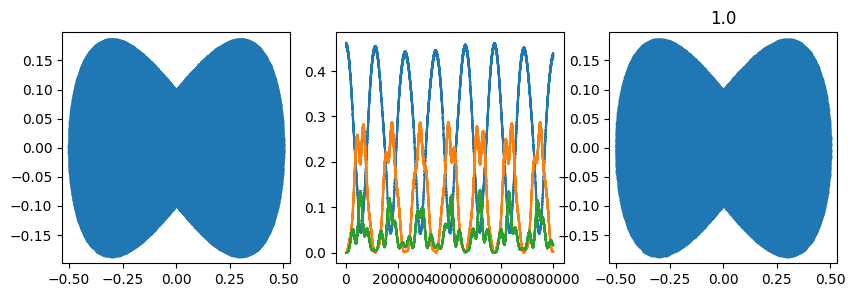

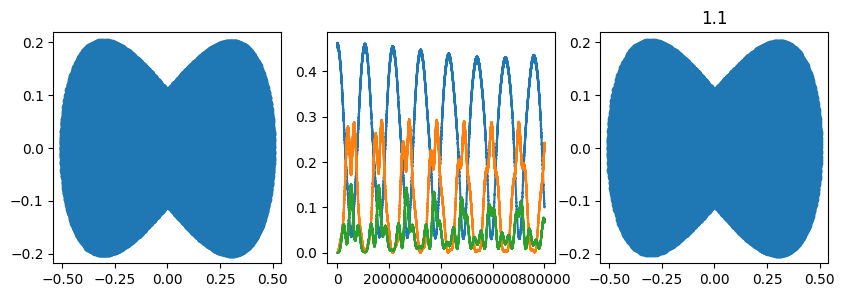

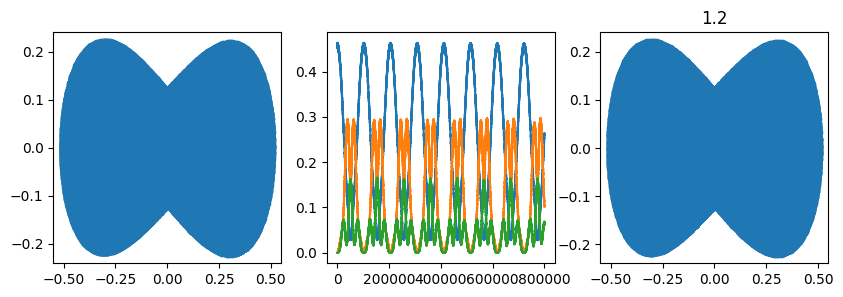

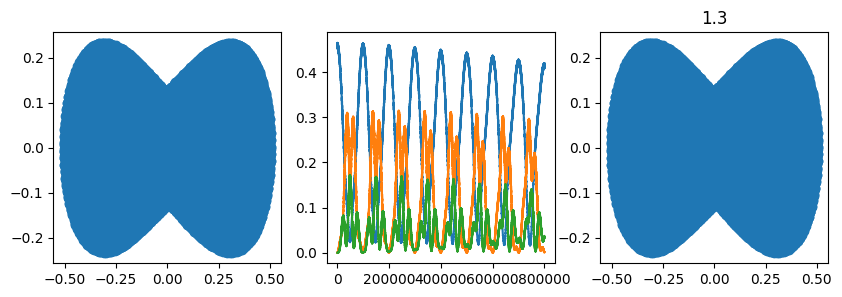

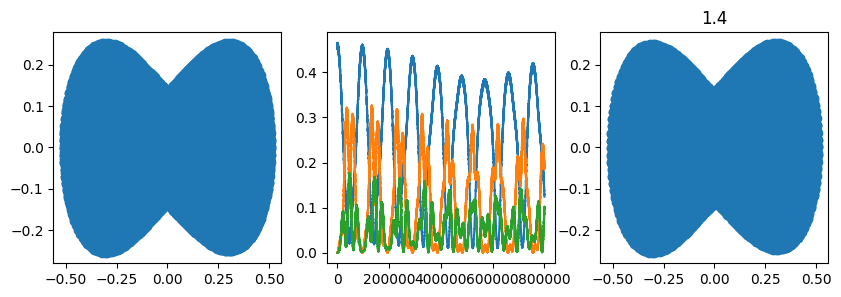

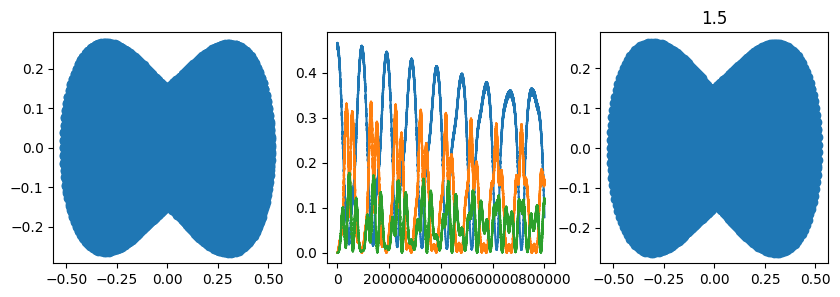

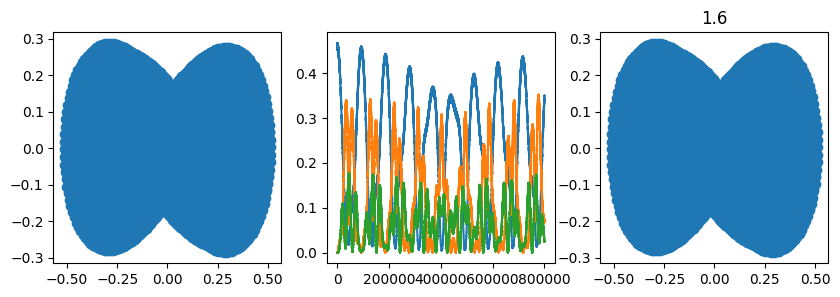

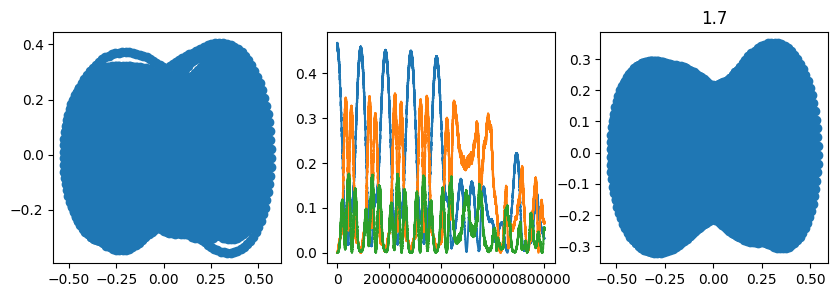

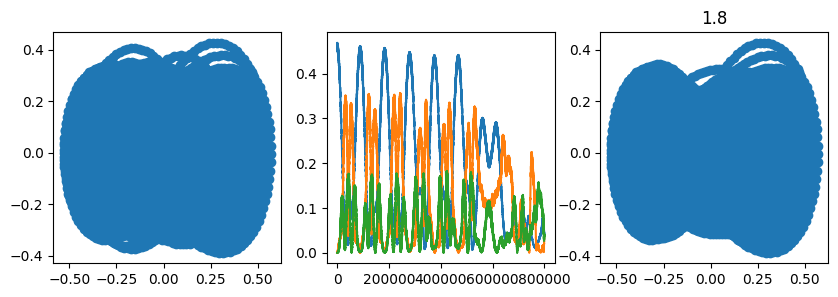

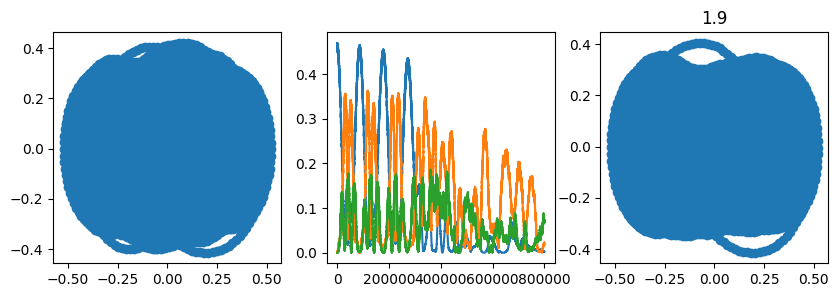

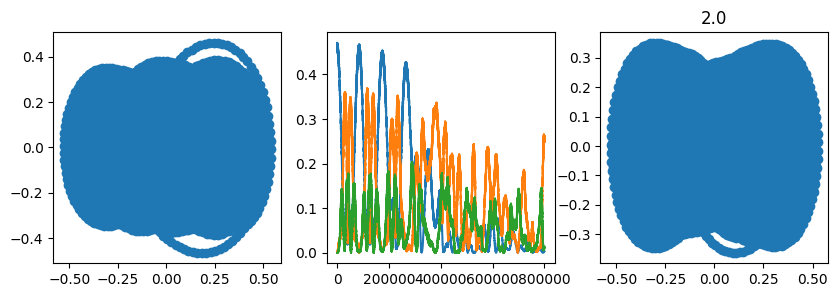

In [9]:
# load and visuliase data

for beta in [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]:

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    data = load_data(DATA_DIR, beta)
    X = data.data_matrix

    q, p = X[:, 0], X[:, 32]

    ax1.scatter(q, p)
    n_portion = 800000

    ax2.plot(data.energy_matrix[:,0][:n_portion], linewidth=1.5, label="Mode 1") 
    ax2.plot(data.energy_matrix[:,2][:n_portion], linewidth=1.5, label="Mode 3")
    ax2.plot(data.energy_matrix[:,4][:n_portion], linewidth=1.5, label="Mode 5")

    X_portion = X[:n_portion]
    q_portion, p_portion = X_portion[:, 0], X_portion[:, 32]

    ax3.scatter(q_portion, p_portion)
    plt.title(beta)
    plt.show()

# print(X.shape, X_portion.shape)

Autoencoder model based on LSTM. It maps initial high-dimensional data (64) onto a lower-dimensional (8) embedding space (`encoder`), and then back to 64 dimensional space (`decoder`).
The mapping learns a compressed representation of the manifold. The recostruction error (MSE) between original data and recostructed data is used as loss for training the model with Adam optimizer.

In [6]:
# train LSTM autoencoder 

from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras import regularizers


def autoencoder_model(timesteps, n_features=64):
    sequential = Sequential()
    sequential.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
    # sequential.add(LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.L1(10e-))) 
    sequential.add(LSTM(8, activation='relu', return_sequences=False))
    sequential.add(RepeatVector(timesteps))
    sequential.add(LSTM(8, activation='relu', return_sequences=True))
    sequential.add(LSTM(32, activation='relu', return_sequences=True))
    sequential.add(TimeDistributed(Dense(n_features)))
    sequential.compile(optimizer='adam', loss='mse')
    return sequential

In [7]:
# temporalise data for. LSTM needs data to be of dim 3, being <sample size, time, num features>
from utils import temporalize_data


timesteps = 5

X = temporalize_data(X_portion, timesteps)
X.shape

(299994, 5, 64)

## Diffusion map Vs beta 

Here we generate diffusion maps on the embedded (encoded) space. <br>

1. We first train an autoencoder on the trajectory data. 

2. After training the autoencoder, we use the `encoder` to project initial data onto lower-dimensional embedding space, where manifold learning is done with Diffusion Map.

In [ ]:
X_dm = {}

In [46]:
from keras.models import Model
from pydiffmap import diffusion_map as dm


for beta in [1.8]:
    data = load_data(DATA_DIR, beta)
    X_portion = data.data_matrix[:800000] 

    X = temporalize_data(X_portion, 5)

    model = autoencoder_model(timesteps)
    model.fit(X, X, epochs=5, batch_size=64, verbose=True)

    encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    X_enc = encoder_model.predict(X)

    neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
    dmap = dm.DiffusionMap.from_sklearn(
        n_evecs=2,
        k=70,
        epsilon=1.0,
        alpha=1.0,
        neighbor_params=neighbor_params)

    X_dm[beta] = dmap.fit_transform(X_enc)

    print()
    print(f'done beta {beta}')
    print()

Epoch 1/5
12500/12500 [==============================] - 49s 4ms/step - loss: 0.0048
Epoch 2/5
12500/12500 [==============================] - 46s 4ms/step - loss: 0.0013
Epoch 3/5
12500/12500 [==============================] - 46s 4ms/step - loss: 0.0011
Epoch 4/5
12500/12500 [==============================] - 47s 4ms/step - loss: 9.1826e-04
Epoch 5/5
25000/25000 [==============================] - 12s 483us/step

done beta 1.8



In [8]:
import pickle

# pickle.dump(X_dm, open("output/03_autoencoder/X_dm.pkl", "wb" ) )
# X_dm = pickle.load( open("output/03_autoencoder/X_dm.pkl", "rb" ) )

Below we visualsie the topological summaries for different $\beta$.
Those are obtained by mean of Diffusion Map on the latent space.

Note that the transition from non-ergotic to ergotic is observed for $\beta$=1.6, as predicted by PCA

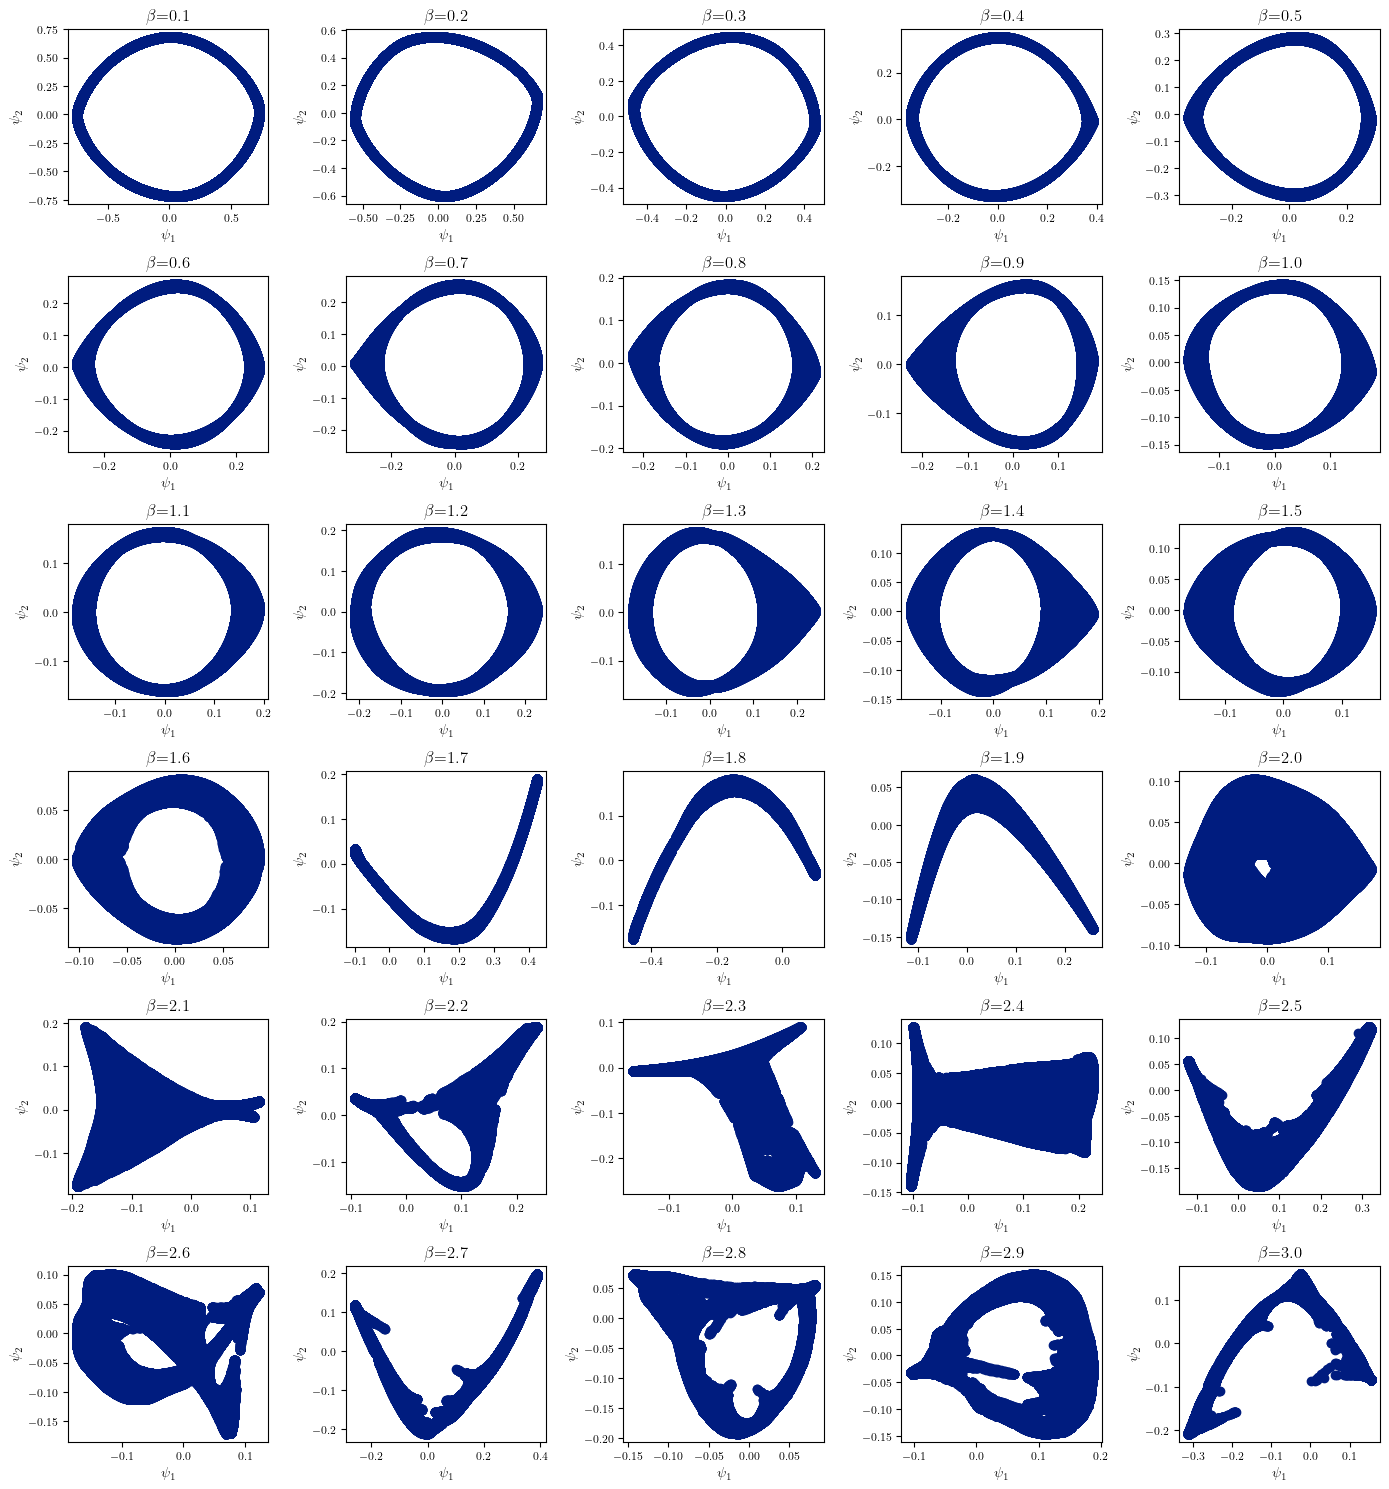

In [47]:
# 'Embedding given by first two DCs'
 
fig, axs = plt.subplots(6, 5, figsize=(14, 15))

for beta, ax in zip(BETA_VALUES, axs.flat):
    ax.scatter(X_dm[beta][:, 0], X_dm[beta][:, 1])
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
    ax.set_title(rf'$\beta$={beta}')

plt.tight_layout()
# plt.savefig("output/03_autoencoder/ac_diff_map_betas.png", dpi=400)